In [4]:
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
import warnings
warnings.simplefilter("ignore")

import scanpy as sc
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

In [5]:
def get_umap_of_removal(in_adata, col_detection=None, detection_method=None):
    adata = in_adata.copy()
    if col_detection is not None:
        adata.obs[col_detection] = adata.obs[col_detection].str.lower()
        adata = adata[adata.obs[col_detection] == "singlet"]
    adata.obs["detectiont_method"] = detection_method

    librarySize = adata.X.sum(axis=1)
    adata.X = adata.to_df().div(librarySize, axis='rows') * 1e+6 # CPM
    adata.X = np.log2(adata.X + 1)
    sc.pp.highly_variable_genes(adata, n_top_genes=3000)
    adata = adata[:, adata.var.highly_variable]
    sc.pp.scale(adata)
    sc.tl.pca(adata, svd_solver='full')
    sc.pp.neighbors(adata, n_pcs = 50)
    sc.tl.umap(adata, n_components=2)
    sc.tl.leiden(adata, resolution = 0.5)
    sc.pl.umap(adata, color=['cell_type', "class", "leiden"])

    umap_data = pd.DataFrame(adata.obsm["X_umap"], columns=["UMAP1", "UMAP2"], index=adata.obs.index)
    umap_data = pd.concat([umap_data, adata.obs], axis=1, ignore_index=False)
    return umap_data

In [6]:
adata = sc.read_h5ad("./expression/results/image-based/adata_img11_wPreds.h5ad")
# adata = adata[adata.obs["pred_image_class"].notnull() & (adata.obs["class"] != "Missing"), ]
adata = adata[adata.obs["class"].notnull() & (~adata.obs["difficult"]), ]

adata_dd = sc.read_h5ad("./expression/results/DoubletDetection/doubletdetection_img11.h5ad")
adata_dd = adata_dd[adata.obs.index, ]
adata.obs["pred_doubletdetection"] = adata_dd.obs["preds_min_cells_0_n_top_genes_all_pvalue_0.0631_vote_thresh_0.3"]

adata_solo = sc.read_h5ad("./expression/results/solo/solo_img11.h5ad")
adata_solo = adata_solo[adata.obs.index, ]
adata.obs["pred_solo"] = adata_solo.obs["preds_min_cells_1_n_top_genes_5000"]

adata_scrublet = sc.read_h5ad("./expression/results/scrublet/scrublet_img11.h5ad")
adata_scrublet = adata_scrublet[adata.obs.index, ]
adata.obs["pred_scrublet"] = adata_scrublet.obs["preds_doublets_thresh_0.06"]

scds = pd.read_csv("./expression/results/scds/scds/scds_img11_doublet_scores.csv", index_col=0)
scds["pred_scds"] = scds["bcds_score"].apply(lambda x: "doublet" if x > 0.5 else "singlet")
scds = scds.set_index("image_pos")
scds = scds.loc[adata.obs.index]
adata.obs["pred_scds"] = scds["pred_scds"]

scdblfinder = pd.read_csv("expression/results/scDblFinder/scDblFinder/results_img11.csv", index_col=0)
scdblfinder = scdblfinder.loc[adata.obs.index]
adata.obs["pred_scDblFinder"] = scdblfinder["scDblFinder.class"]

doubletfinder = pd.read_csv("expression/results/DoubletFinder/DoubletFinder/results_img11.csv", index_col=0)
doubletfinder = doubletfinder.loc[adata.obs.index]
adata.obs["pred_doubletfinder"] = doubletfinder["DF.classifications_0.25_0.06_41"]

adata_img11 = adata.copy()
adata_img11.obs = adata_img11.obs.reset_index().set_index("image_pos", drop=False)
adata_img11.obs[['COL', 'ROW']] = adata_img11.obs['image_pos'].str.split('_', expand=True)
# Extract only the numbers
adata_img11.obs['COL'] = adata_img11.obs['COL'].str.extract('(\d+)')
adata_img11.obs['ROW'] = adata_img11.obs['ROW'].str.extract('(\d+)')
# Convert the columns to numeric type
adata_img11.obs['COL'] = pd.to_numeric(adata_img11.obs['COL'])
adata_img11.obs['ROW'] = pd.to_numeric(adata_img11.obs['ROW'])

adata_img11.obs.loc[adata_img11.obs.COL > 10, "cell_type"] = "SUM190"
adata_img11.obs.loc[adata_img11.obs.COL <= 10, "cell_type"] = "SUM149"

In [7]:
adata = sc.read_h5ad("./expression/results/image-based/adata_img5_wPreds.h5ad")
# adata = adata[adata.obs["pred_image_class"].notnull() & (adata.obs["class"] != "Missing"), ]
adata = adata[adata.obs["class"].notnull(), ]

adata_dd = sc.read_h5ad("./expression/results/DoubletDetection/doubletdetection_img5.h5ad")
adata_dd = adata_dd[adata.obs.index, ]
adata.obs["pred_doubletdetection"] = adata_dd.obs["preds_min_cells_0_n_top_genes_all_pvalue_0.0100_vote_thresh_0.6"]

adata_solo = sc.read_h5ad("./expression/results/solo/solo_img5.h5ad")
adata_solo = adata_solo[adata.obs.index, ]
adata.obs["pred_solo"] = adata_solo.obs["preds_min_cells_0_n_top_genes_5000"]

adata_scrublet = sc.read_h5ad("./expression/results/scrublet/scrublet_img5.h5ad")
adata_scrublet = adata_scrublet[adata.obs.index, ]
adata.obs["pred_scrublet"] = adata_scrublet.obs["preds_doublets_thresh_0.06"]

scds = pd.read_csv("./expression/results/scds/scds/scds_img5_doublet_scores.csv", index_col=0)
scds["pred_scds"] = scds["bcds_score"].apply(lambda x: "doublet" if x > 0.4 else "singlet")
scds = scds.set_index("image_pos")
scds = scds.loc[adata.obs.index]
adata.obs["pred_scds"] = scds["pred_scds"]

scdblfinder = pd.read_csv("expression/results/scDblFinder/scDblFinder/results_img5.csv", index_col=0)
scdblfinder = scdblfinder.loc[adata.obs.index]
adata.obs["pred_scDblFinder"] = scdblfinder["scDblFinder.class"]

doubletfinder = pd.read_csv("expression/results/DoubletFinder/DoubletFinder/results_img5.csv", index_col=0)
doubletfinder = doubletfinder.loc[adata.obs.index]
adata.obs["pred_doubletfinder"] = doubletfinder["DF.classifications_0.25_0.25_41"]

adata_img5 = adata.copy()
adata_img5.obs = adata_img5.obs.reset_index().set_index("image_pos", drop=False)
adata_img5.obs[['COL', 'ROW']] = adata_img5.obs['image_pos'].str.split('_', expand=True)
# Extract only the numbers
adata_img5.obs['COL'] = adata_img5.obs['COL'].str.extract('(\d+)')
adata_img5.obs['ROW'] = adata_img5.obs['ROW'].str.extract('(\d+)')
# Convert the columns to numeric type
adata_img5.obs['COL'] = pd.to_numeric(adata_img5.obs['COL'])
adata_img5.obs['ROW'] = pd.to_numeric(adata_img5.obs['ROW'])

adata_img5.obs.loc[adata_img5.obs.COL > 10, "cell_type"] = "H1975"
adata_img5.obs.loc[adata_img5.obs.COL <= 10, "cell_type"] = "SUM149"

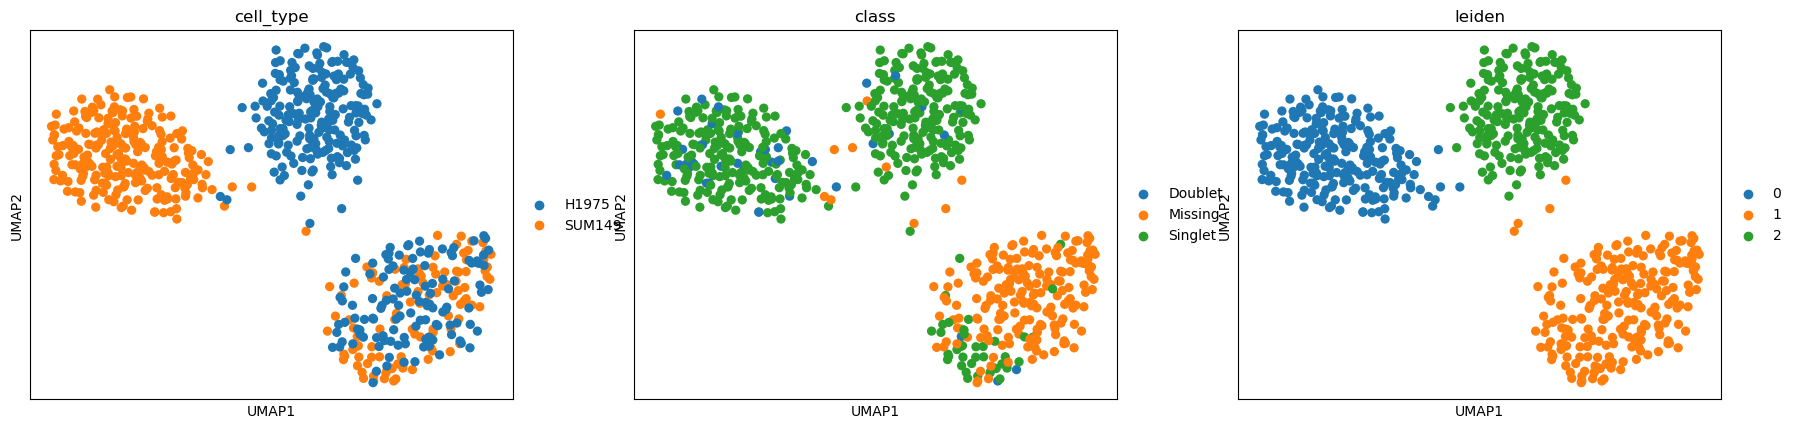

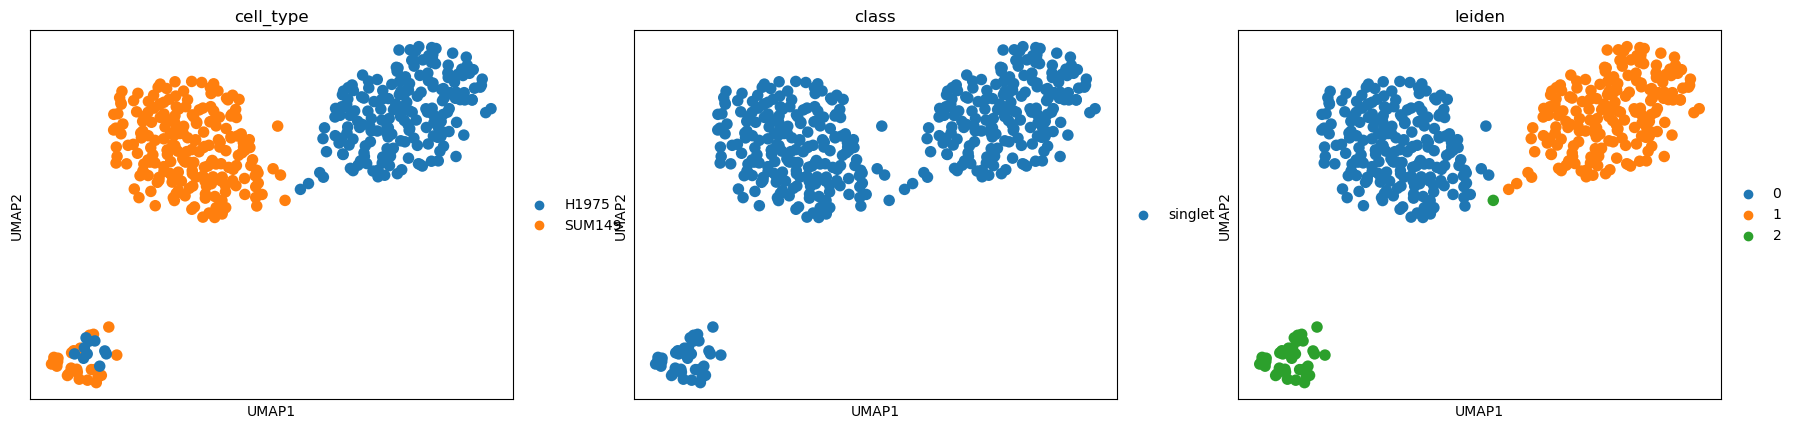

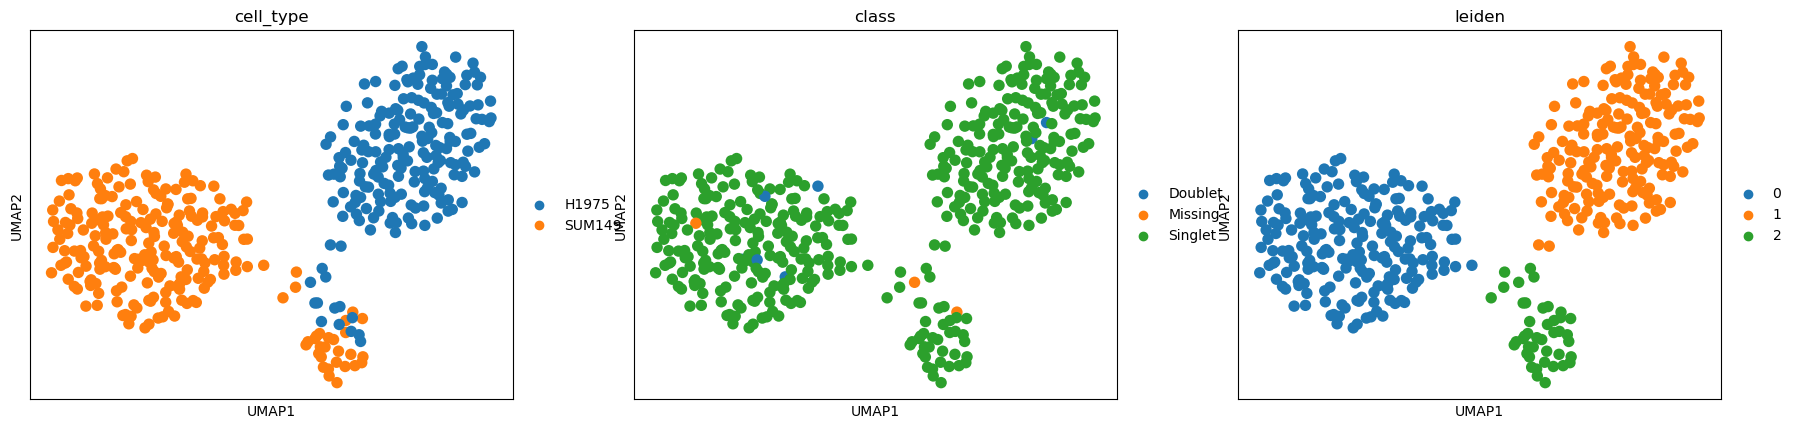

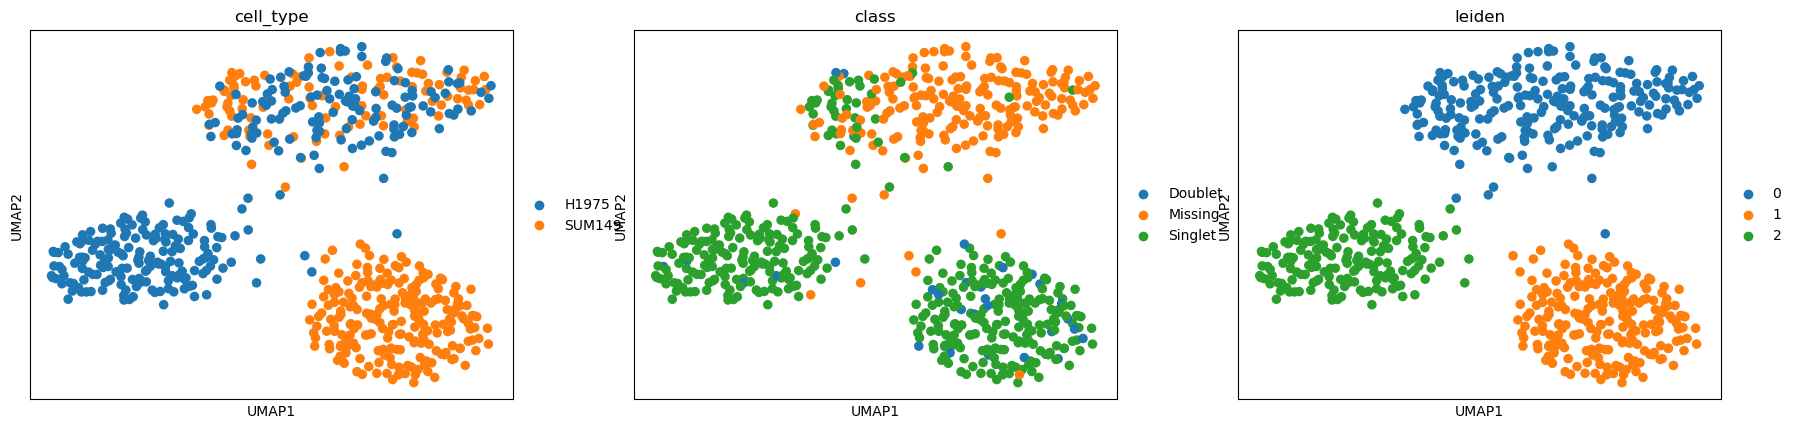

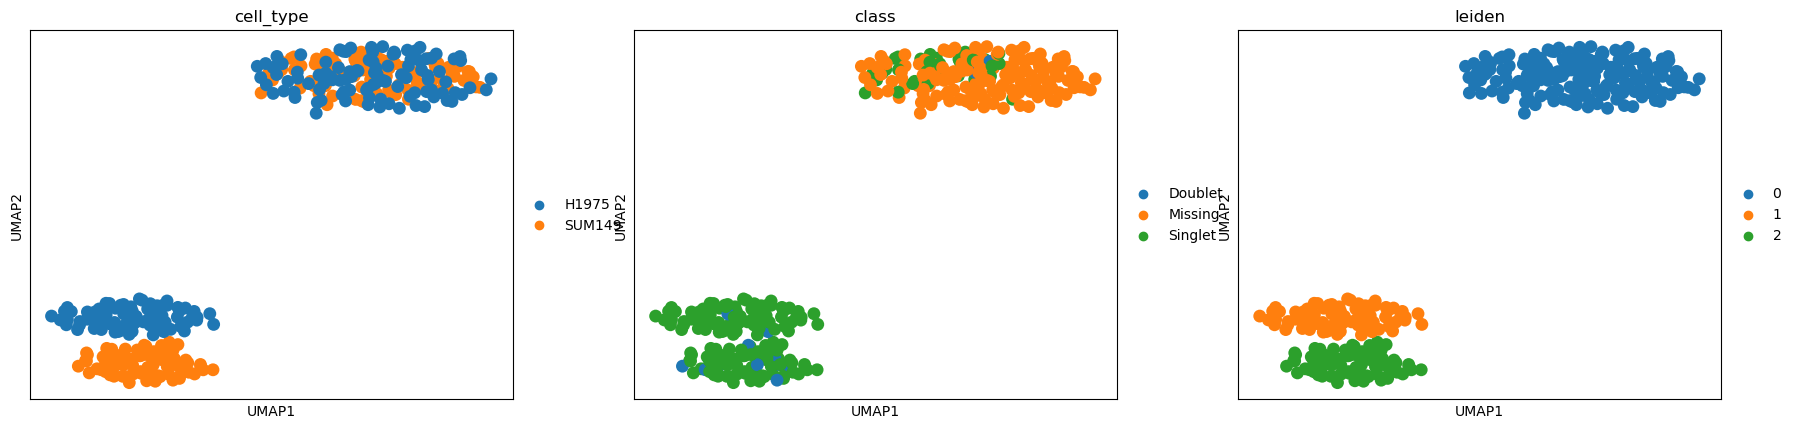

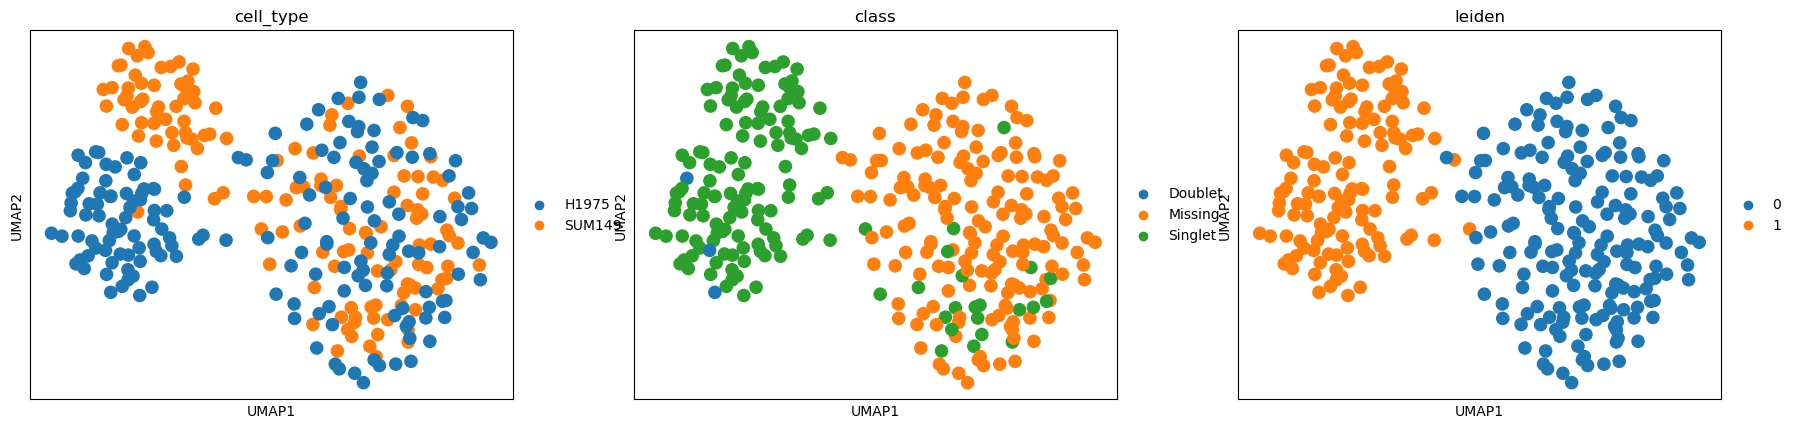

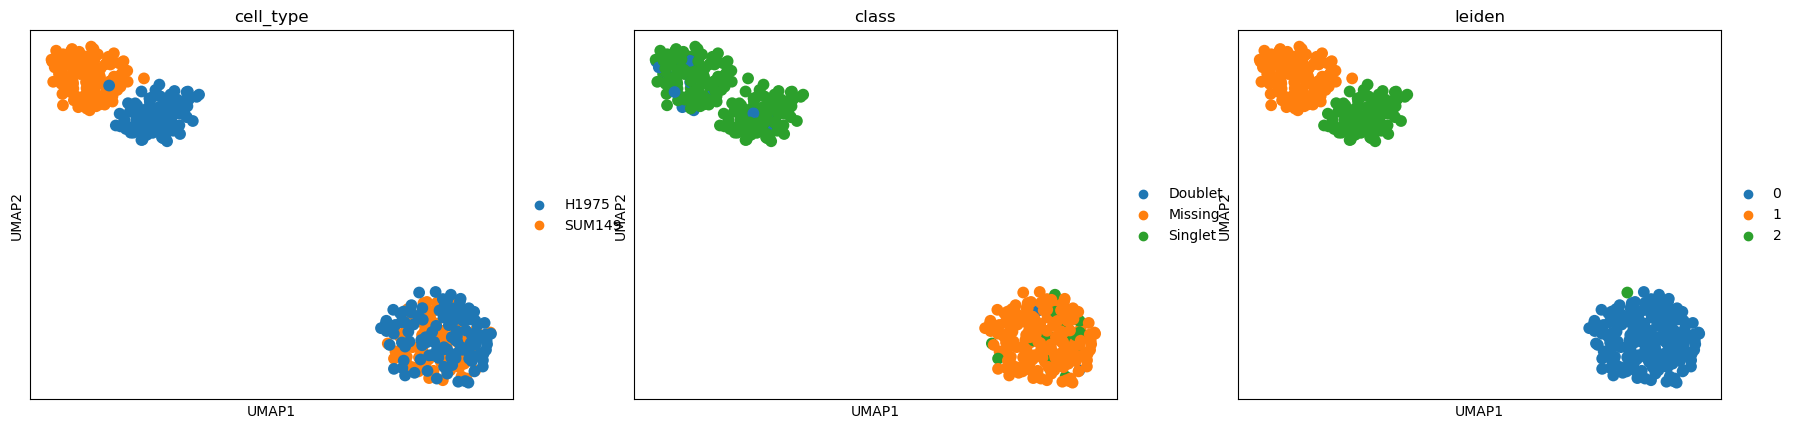

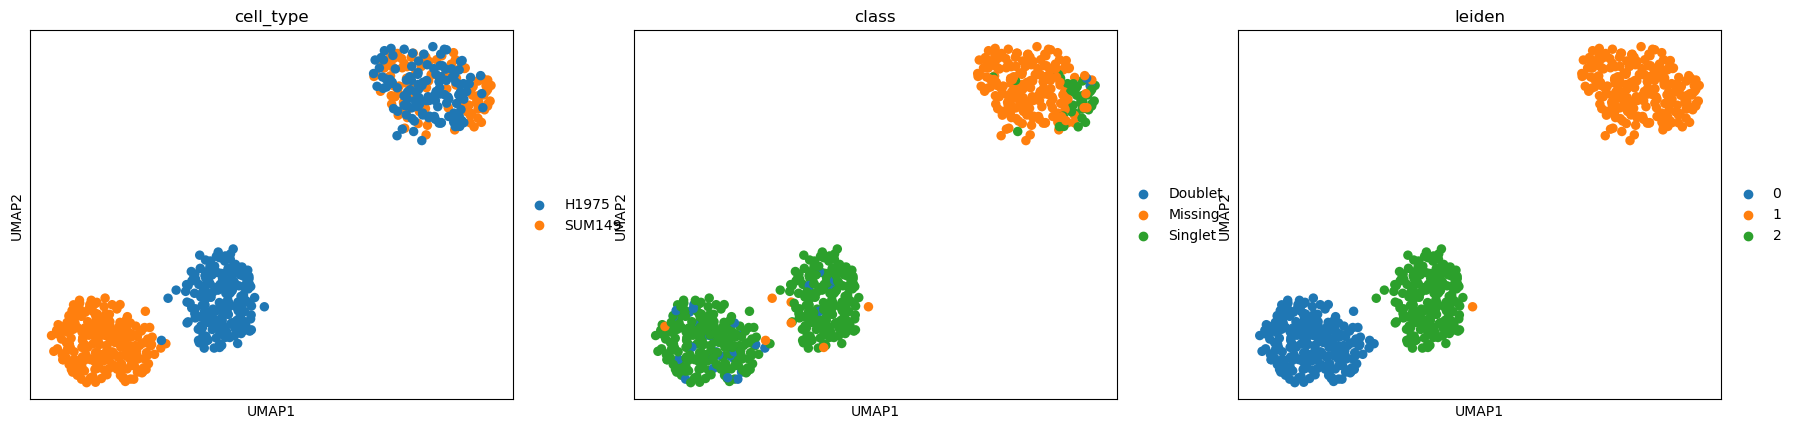

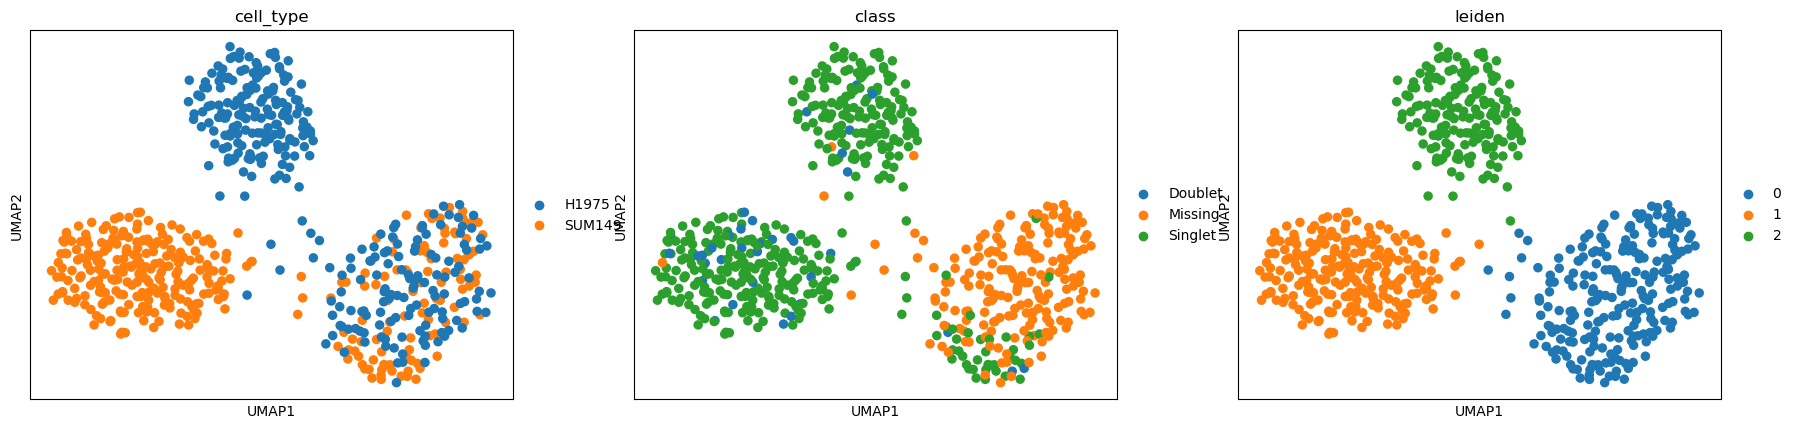

In [8]:
umap_data_of_removal = pd.DataFrame()
umap_data_of_removal = pd.concat([
    umap_data_of_removal,
    get_umap_of_removal(adata_img5, None, "no removal"),
    get_umap_of_removal(adata_img5, "class", "Ground-truth"),
    get_umap_of_removal(adata_img5, "pred_image_class", "ImageDoubler"),
    get_umap_of_removal(adata_img5, "pred_doubletdetection", "DoubletDetection"),
    get_umap_of_removal(adata_img5, "pred_scrublet", "Scrublet"),
    get_umap_of_removal(adata_img5, "pred_solo", "Solo"),
    get_umap_of_removal(adata_img5, "pred_scds", "scds"),
    get_umap_of_removal(adata_img5, "pred_scDblFinder", "scDblFinder"),
    get_umap_of_removal(adata_img5, "pred_doubletfinder", "DoubletFinder"),
], ignore_index=True)
umap_data_of_removal.to_csv("Figure5/umap_data_removal_img5.csv", index=False)

cluster_acc = []
for method in np.unique(umap_data_of_removal["detectiont_method"]):
    cluster_acc.append(
        [
            method,
            adjusted_mutual_info_score(
                umap_data_of_removal.loc[umap_data_of_removal["detectiont_method"] == method, "cell_type"],
                umap_data_of_removal.loc[umap_data_of_removal["detectiont_method"] == method, "leiden"],
            ),
            adjusted_rand_score(
                umap_data_of_removal.loc[umap_data_of_removal["detectiont_method"] == method, "cell_type"],
                umap_data_of_removal.loc[umap_data_of_removal["detectiont_method"] == method, "leiden"],
            ),
        ]
    )
cluster_acc = pd.DataFrame(cluster_acc, columns=["method", "AMI", "RI"])
cluster_acc.to_csv("Figure5/cluster_acc_img5.csv", index=False)

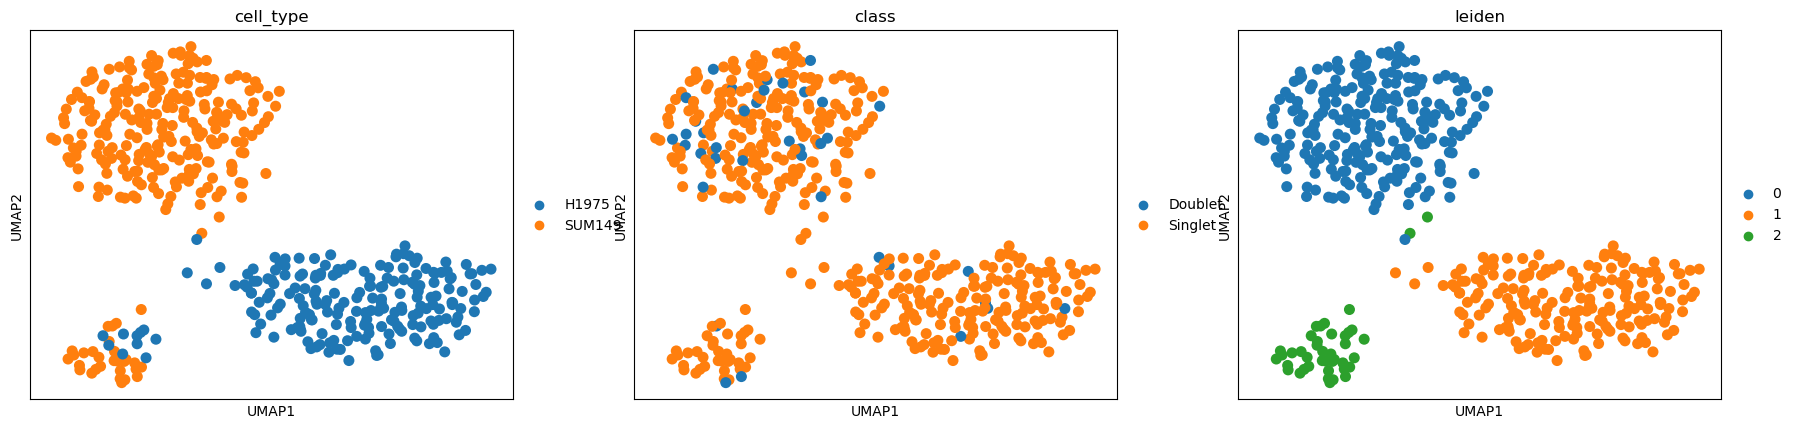

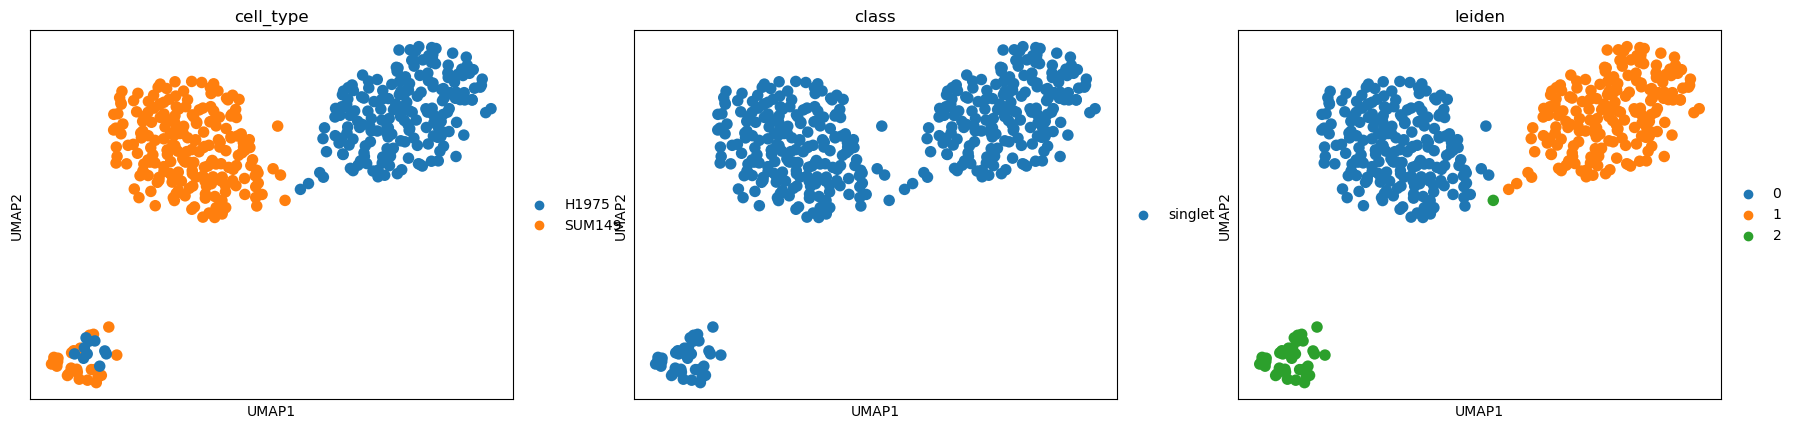

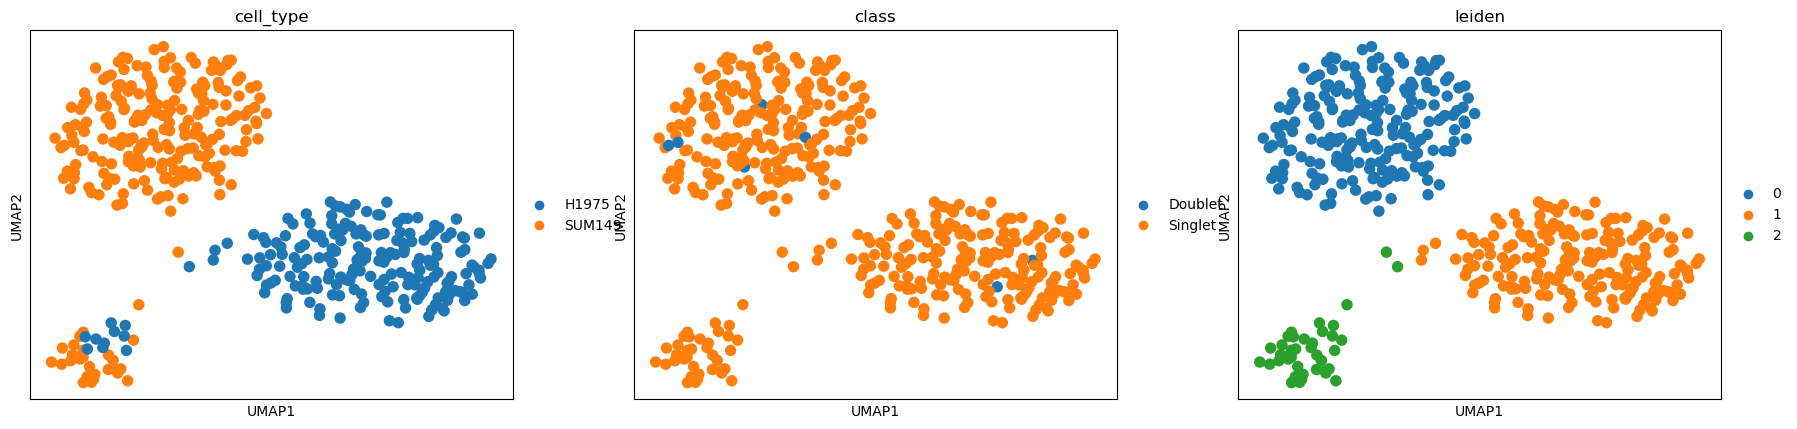

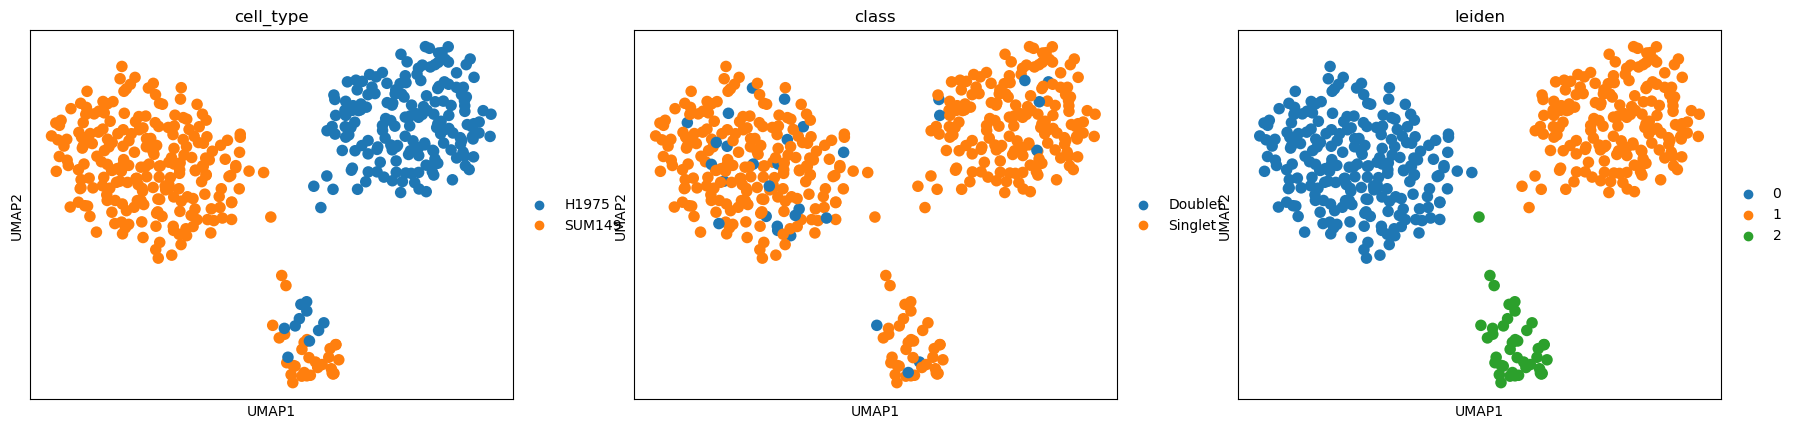

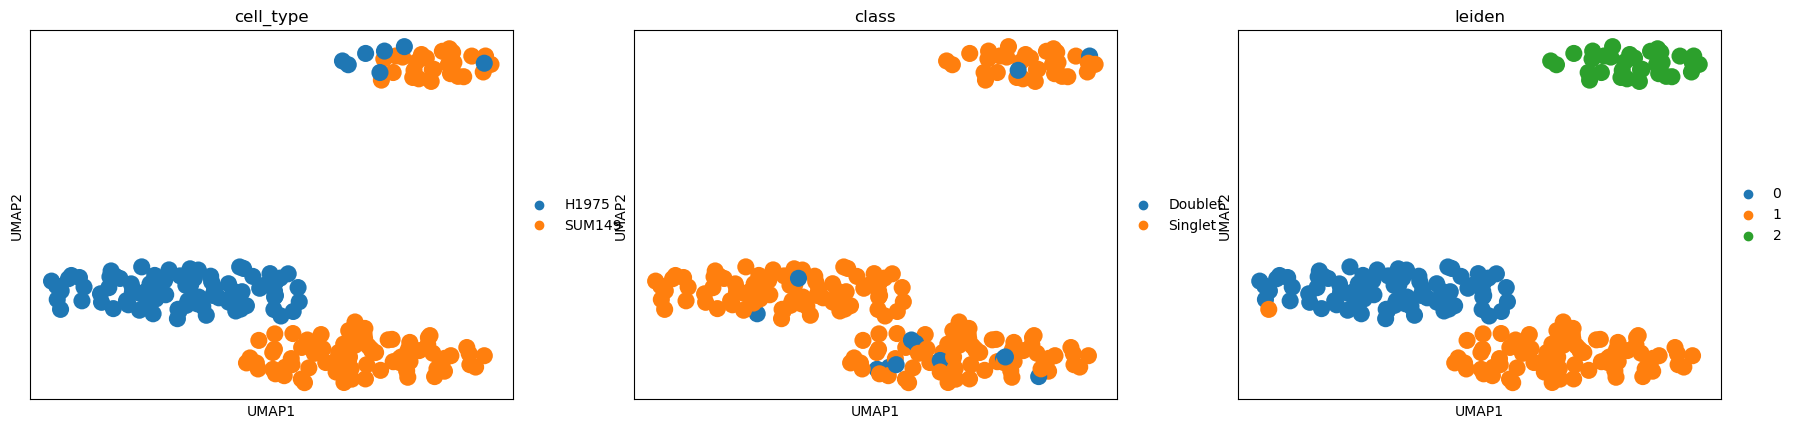

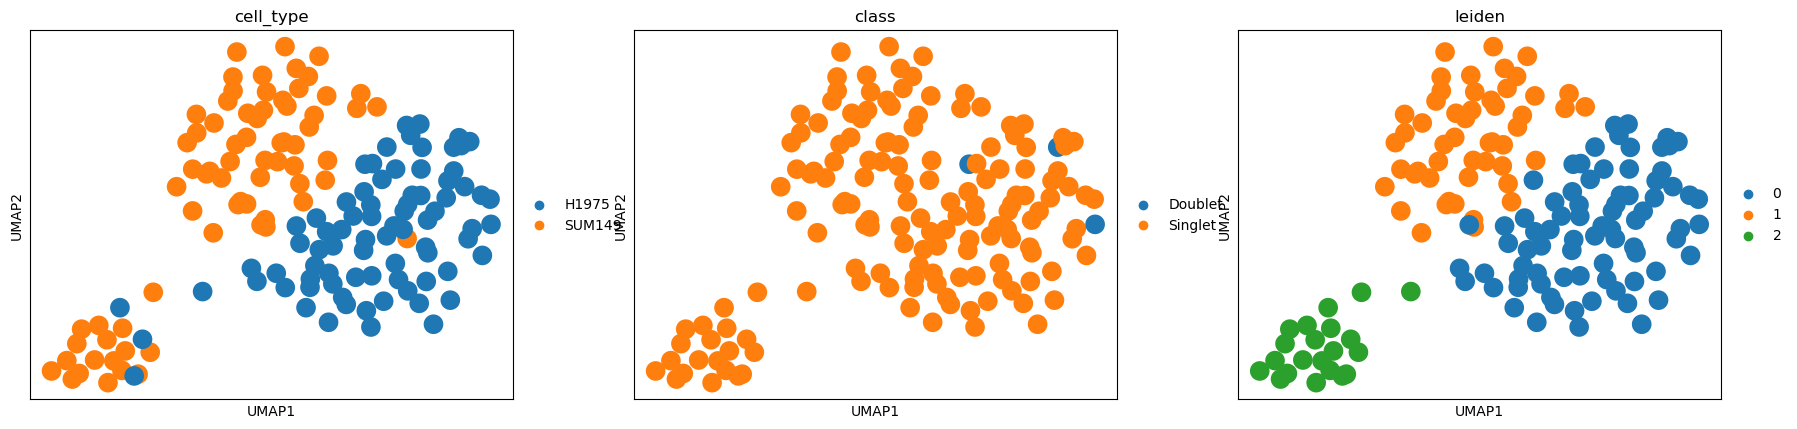

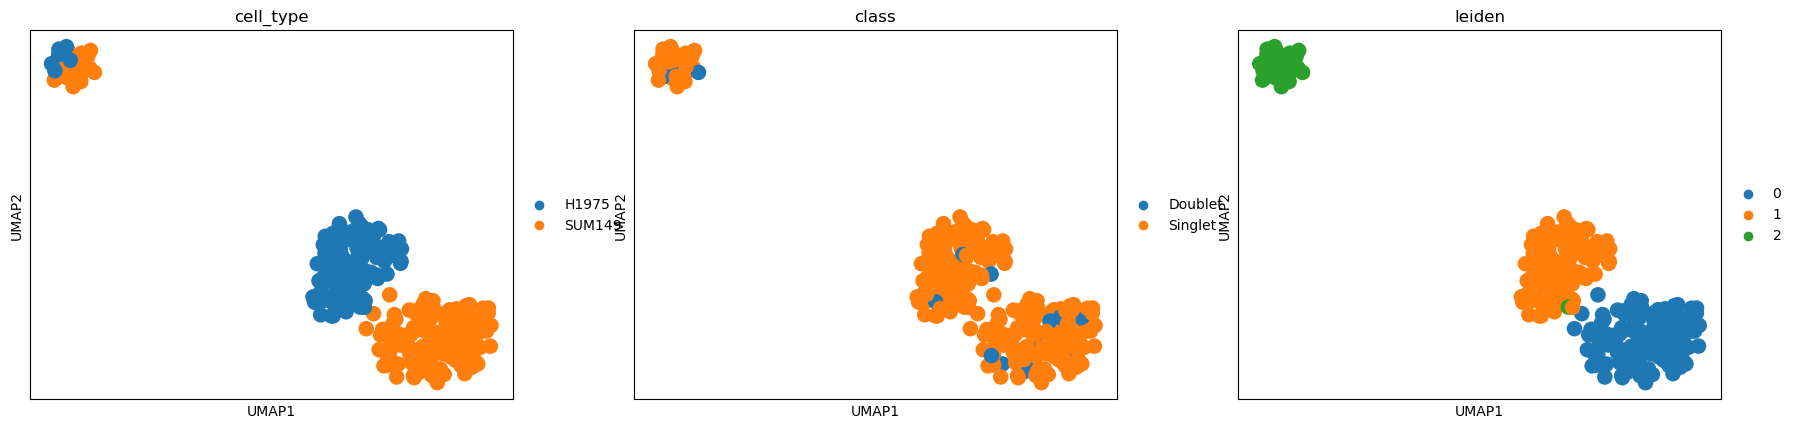

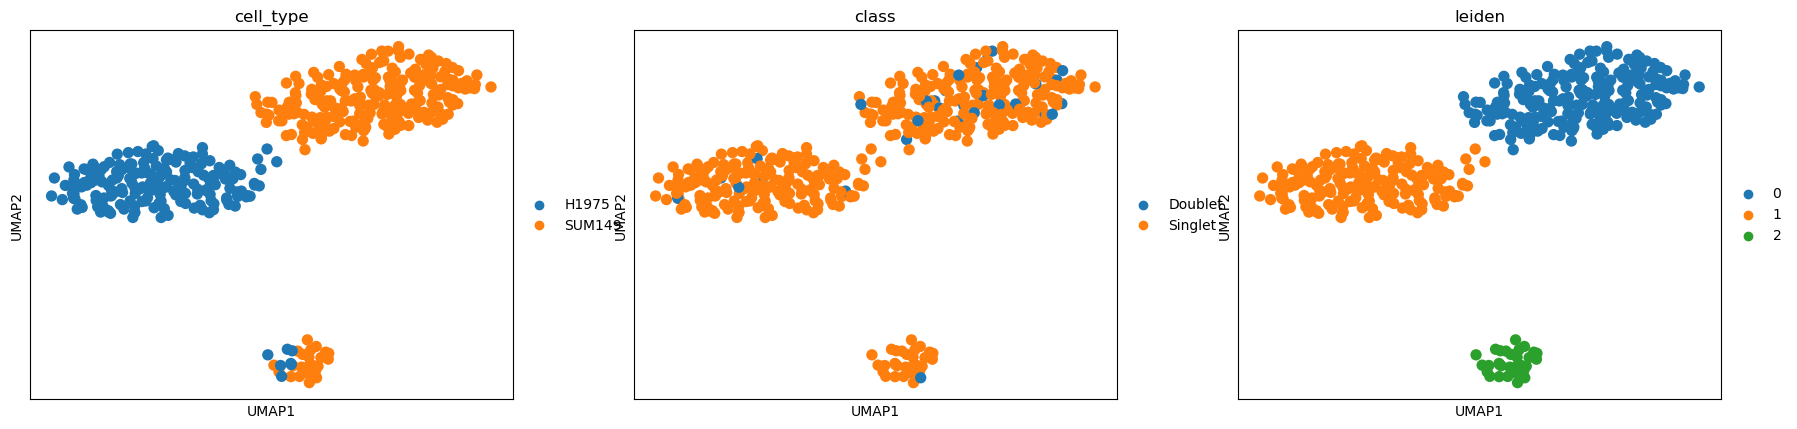

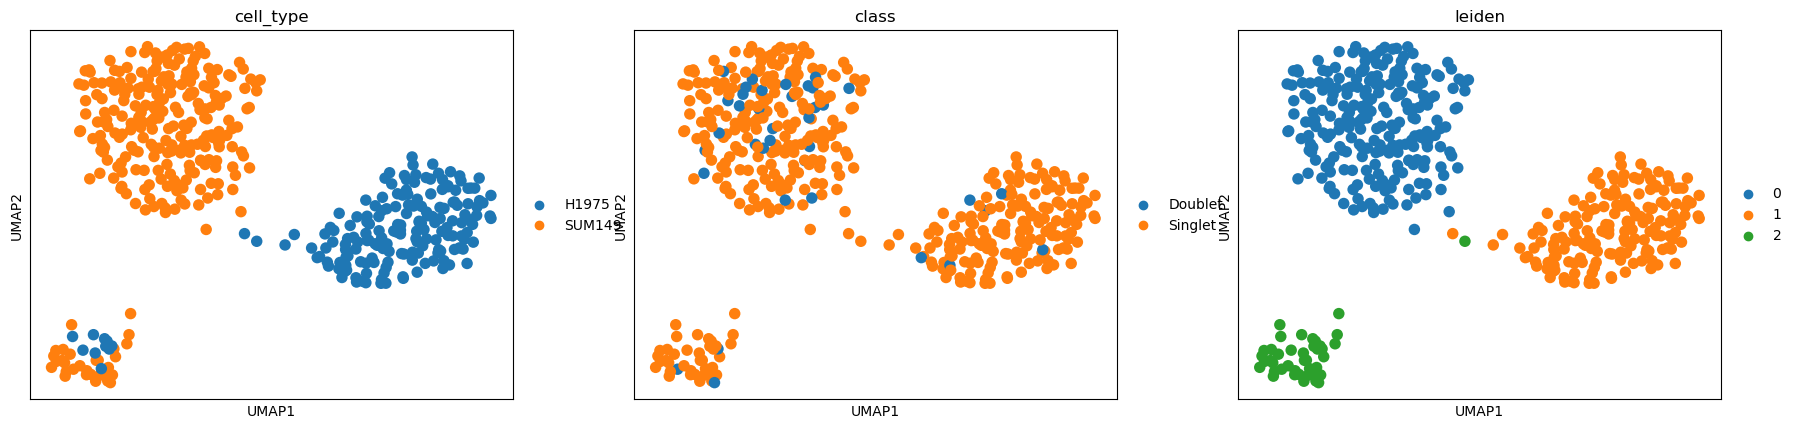

In [9]:
# try removing the missings
adata_img5 = adata_img5[adata_img5.obs["class"] != "Missing"]
umap_data_of_removal = pd.DataFrame()
umap_data_of_removal = pd.concat([
    umap_data_of_removal,
    get_umap_of_removal(adata_img5, None, "no removal"),
    get_umap_of_removal(adata_img5, "class", "Ground-truth"),
    get_umap_of_removal(adata_img5, "pred_image_class", "ImageDoubler"),
    get_umap_of_removal(adata_img5, "pred_doubletdetection", "DoubletDetection"),
    get_umap_of_removal(adata_img5, "pred_scrublet", "Scrublet"),
    get_umap_of_removal(adata_img5, "pred_solo", "Solo"),
    get_umap_of_removal(adata_img5, "pred_scds", "scds"),
    get_umap_of_removal(adata_img5, "pred_scDblFinder", "scDblFinder"),
    get_umap_of_removal(adata_img5, "pred_doubletfinder", "DoubletFinder"),
], ignore_index=True)
umap_data_of_removal.to_csv("Figure5/umap_data_removal_img5_noMissing.csv", index=False)

cluster_acc = []
for method in np.unique(umap_data_of_removal["detectiont_method"]):
    cluster_acc.append(
        [
            method,
            adjusted_mutual_info_score(
                umap_data_of_removal.loc[umap_data_of_removal["detectiont_method"] == method, "cell_type"],
                umap_data_of_removal.loc[umap_data_of_removal["detectiont_method"] == method, "leiden"],
            ),
            adjusted_rand_score(
                umap_data_of_removal.loc[umap_data_of_removal["detectiont_method"] == method, "cell_type"],
                umap_data_of_removal.loc[umap_data_of_removal["detectiont_method"] == method, "leiden"],
            ),
        ]
    )
cluster_acc = pd.DataFrame(cluster_acc, columns=["method", "AMI", "RI"])
cluster_acc.to_csv("Figure5/cluster_acc_img5_noMissing.csv", index=False)

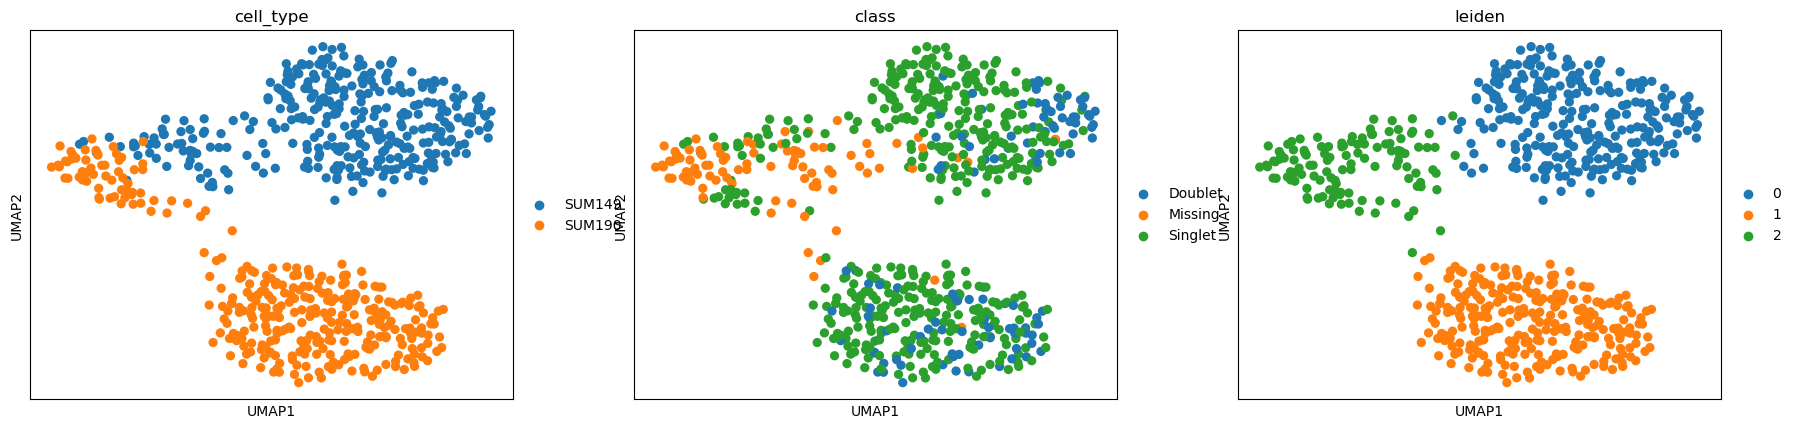

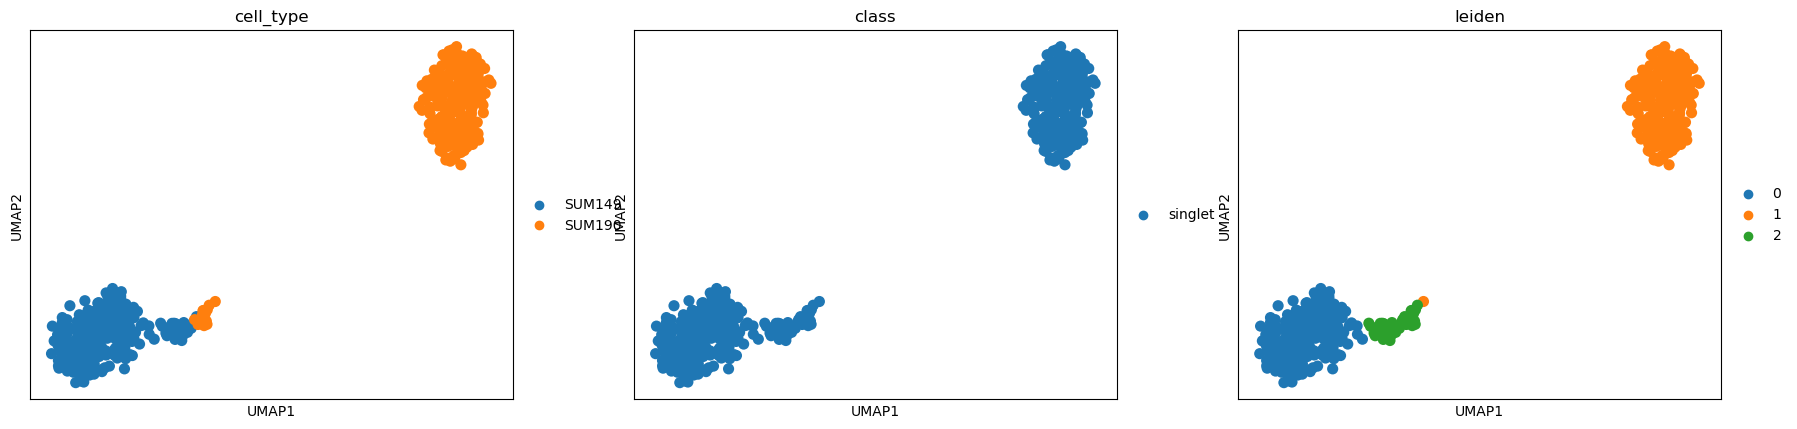

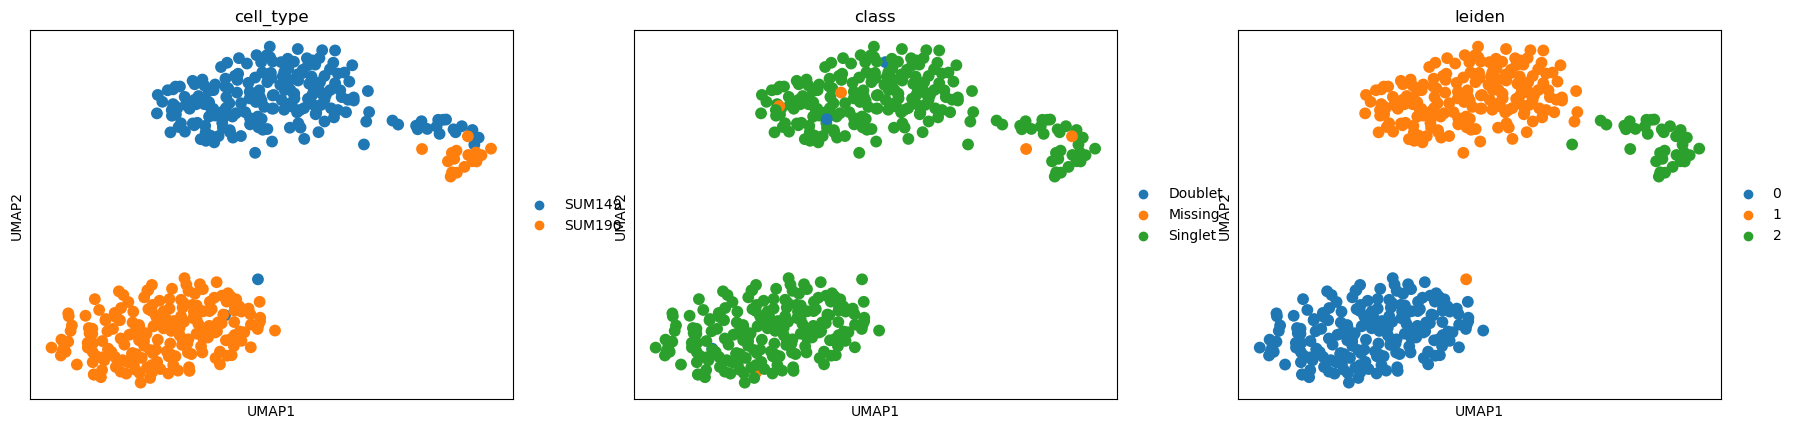

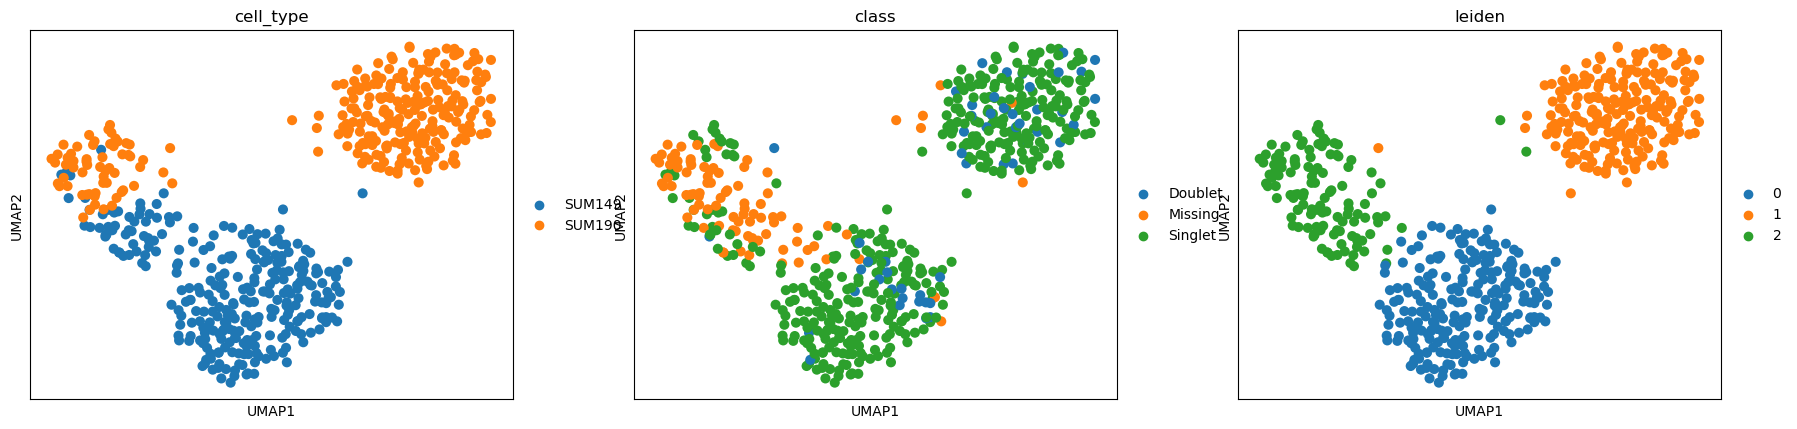

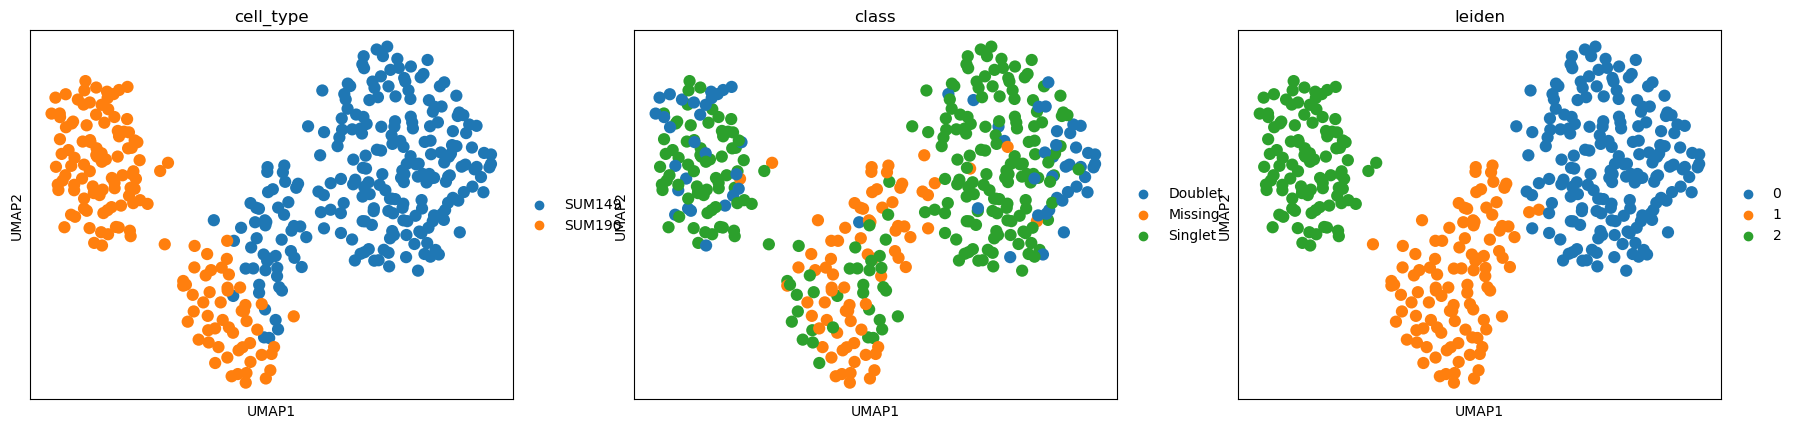

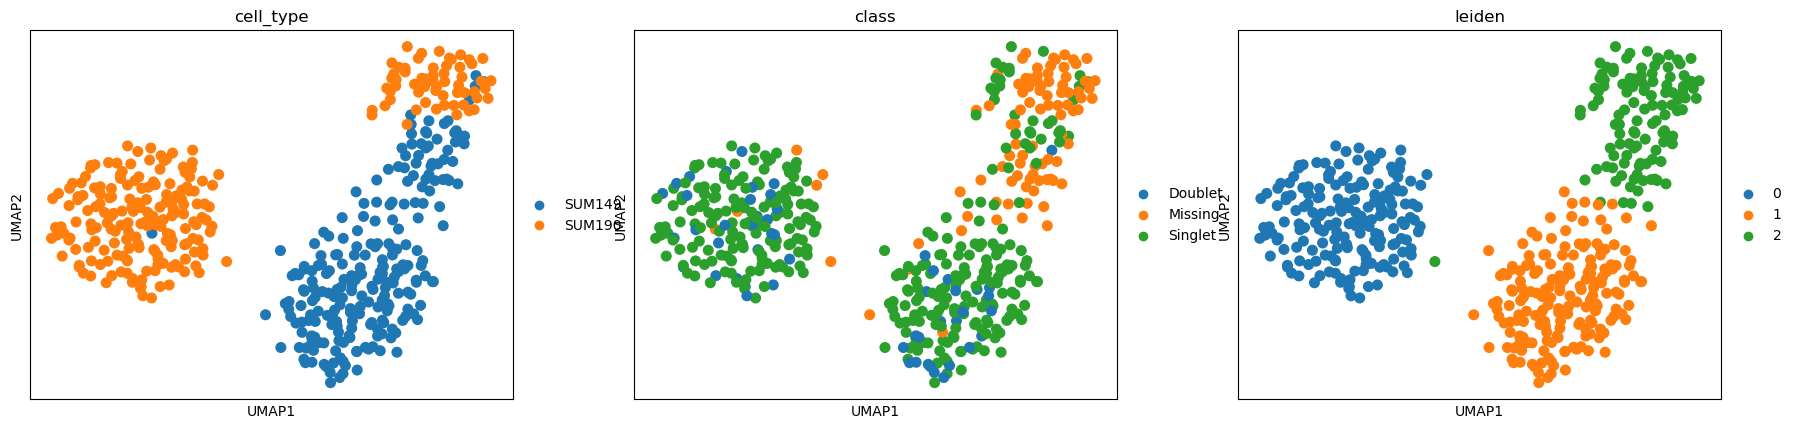

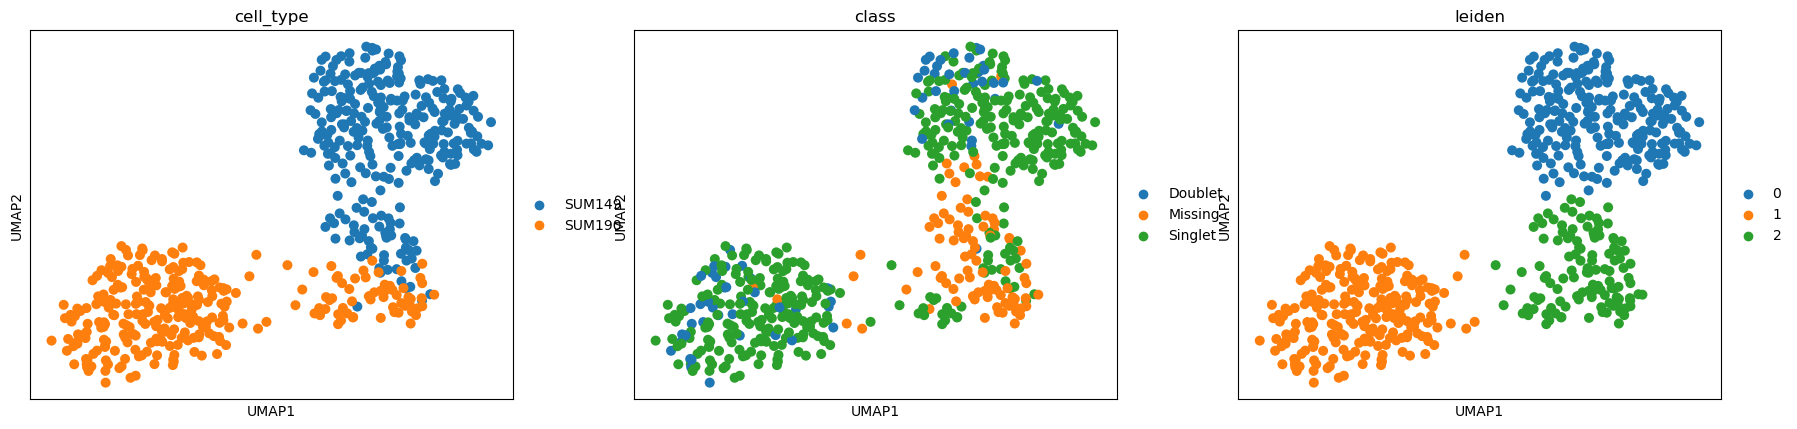

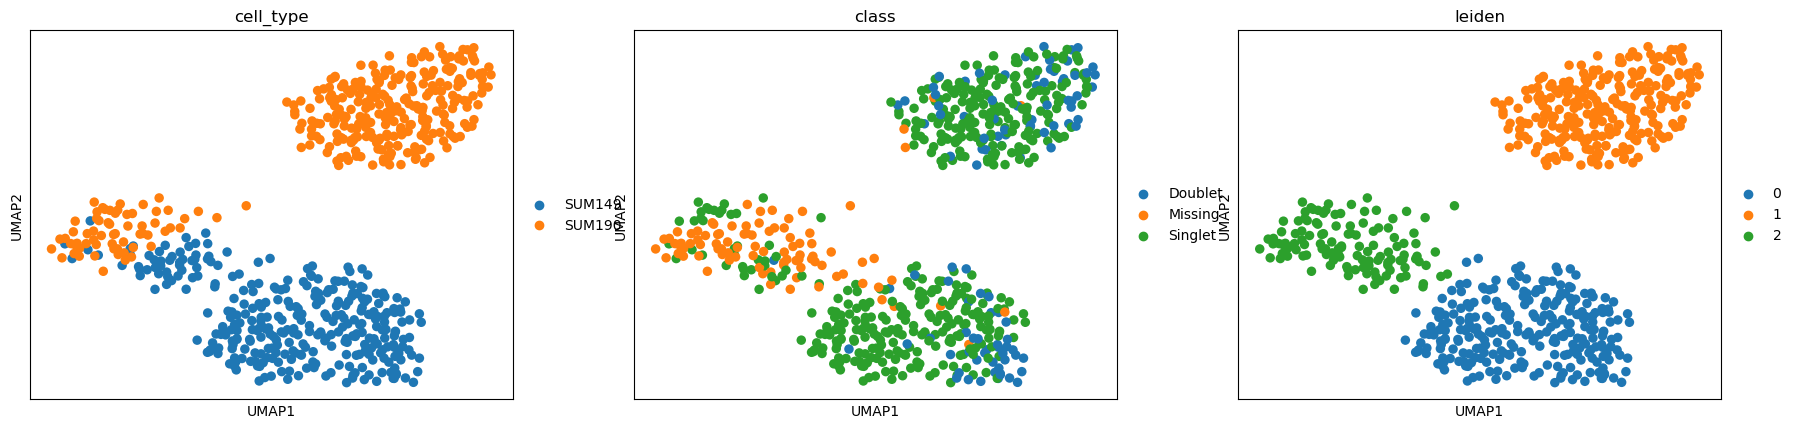

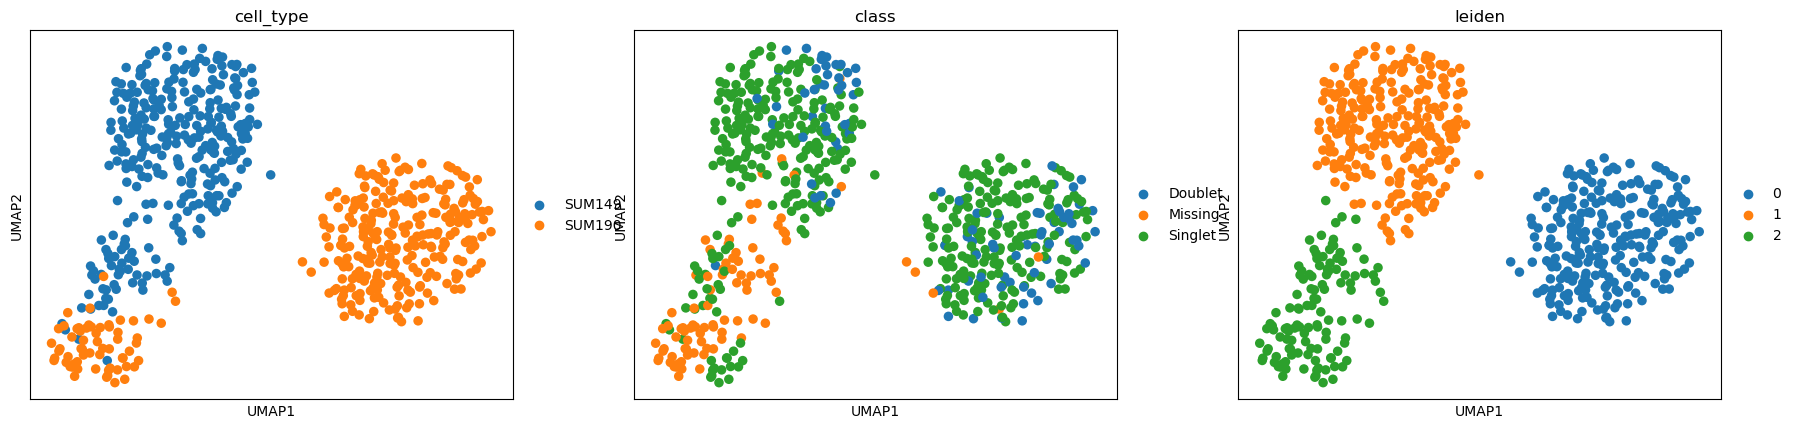

In [10]:
umap_data_of_removal = pd.DataFrame()
umap_data_of_removal = pd.concat([
    umap_data_of_removal,
    get_umap_of_removal(adata_img11, None, "no removal"),
    get_umap_of_removal(adata_img11, "class", "Ground-truth"),
    get_umap_of_removal(adata_img11, "pred_image_class", "ImageDoubler"),
    get_umap_of_removal(adata_img11, "pred_doubletdetection", "DoubletDetection"),
    get_umap_of_removal(adata_img11, "pred_scrublet", "Scrublet"),
    get_umap_of_removal(adata_img11, "pred_solo", "Solo"),
    get_umap_of_removal(adata_img11, "pred_scds", "scds"),
    get_umap_of_removal(adata_img11, "pred_scDblFinder", "scDblFinder"),
    get_umap_of_removal(adata_img11, "pred_doubletfinder", "DoubletFinder"),
], ignore_index=True);
umap_data_of_removal.to_csv("Figure5/umap_data_removal_img11.csv", index=False)

cluster_acc = []
for method in np.unique(umap_data_of_removal["detectiont_method"]):
    cluster_acc.append(
        [
            method,
            adjusted_mutual_info_score(
                umap_data_of_removal.loc[umap_data_of_removal["detectiont_method"] == method, "cell_type"],
                umap_data_of_removal.loc[umap_data_of_removal["detectiont_method"] == method, "leiden"],
            ),
            adjusted_rand_score(
                umap_data_of_removal.loc[umap_data_of_removal["detectiont_method"] == method, "cell_type"],
                umap_data_of_removal.loc[umap_data_of_removal["detectiont_method"] == method, "leiden"],
            ),
        ]
    )
cluster_acc = pd.DataFrame(cluster_acc, columns=["method", "AMI", "RI"])
cluster_acc.to_csv("Figure5/cluster_acc_img11.csv", index=False)

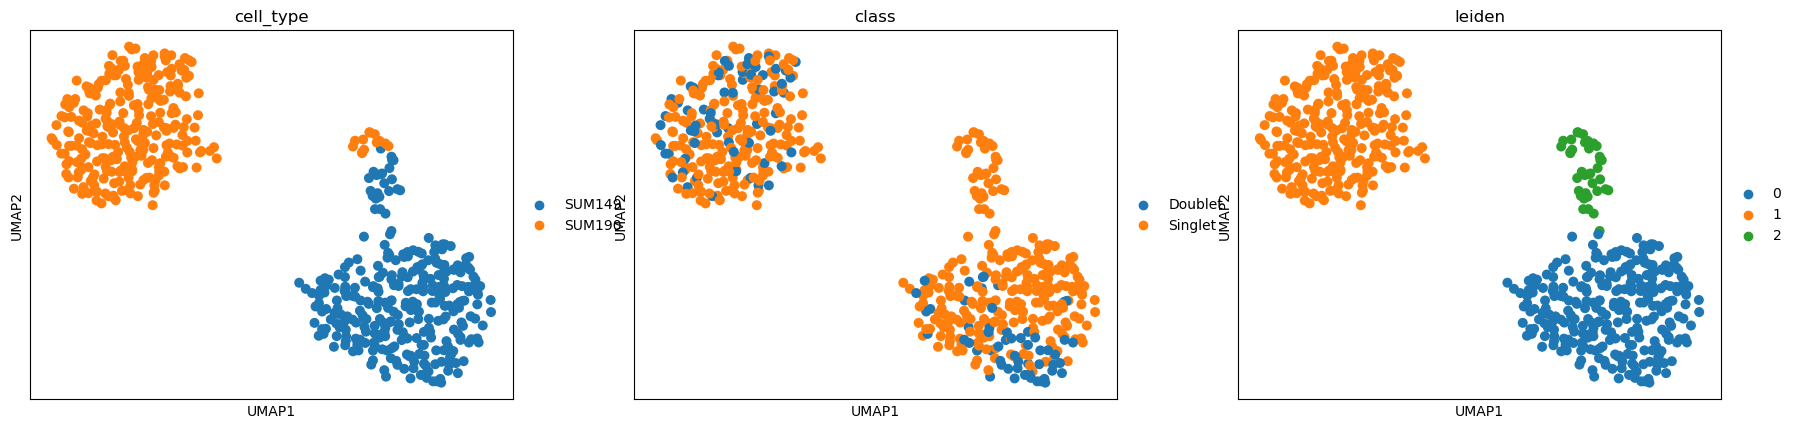

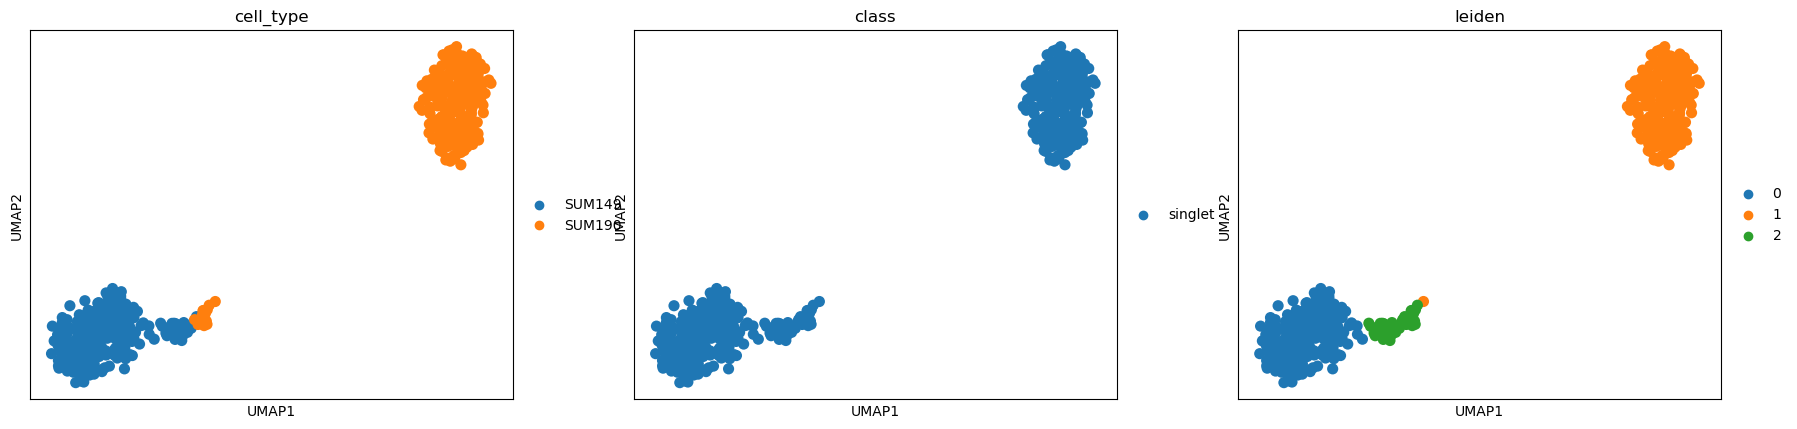

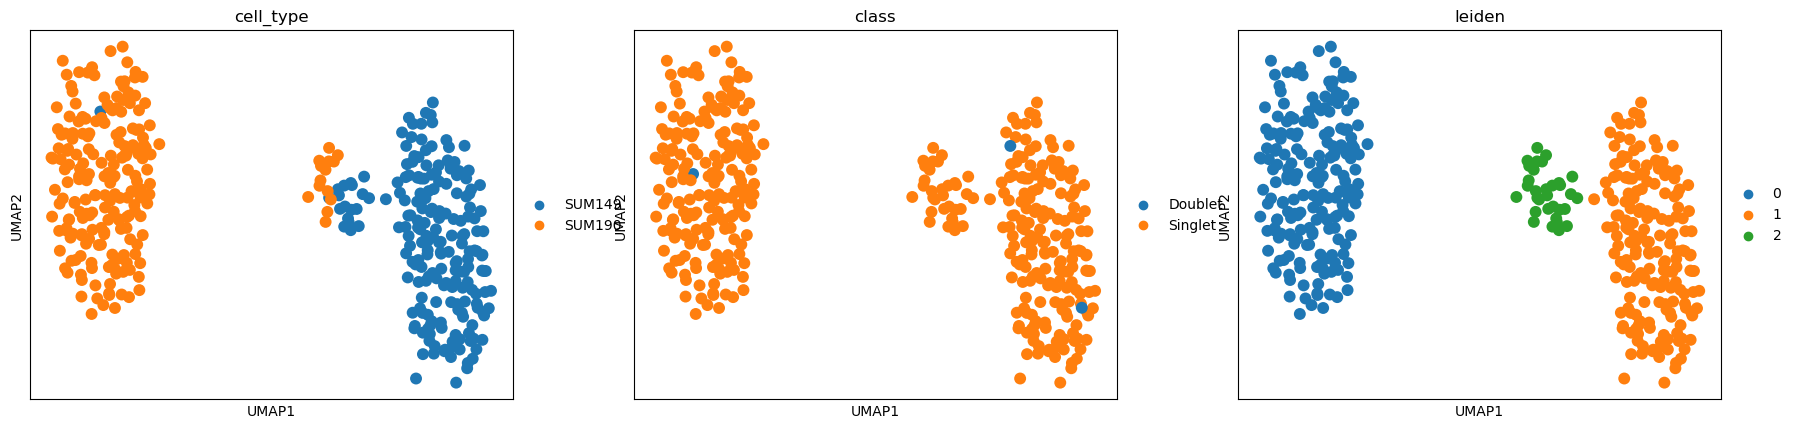

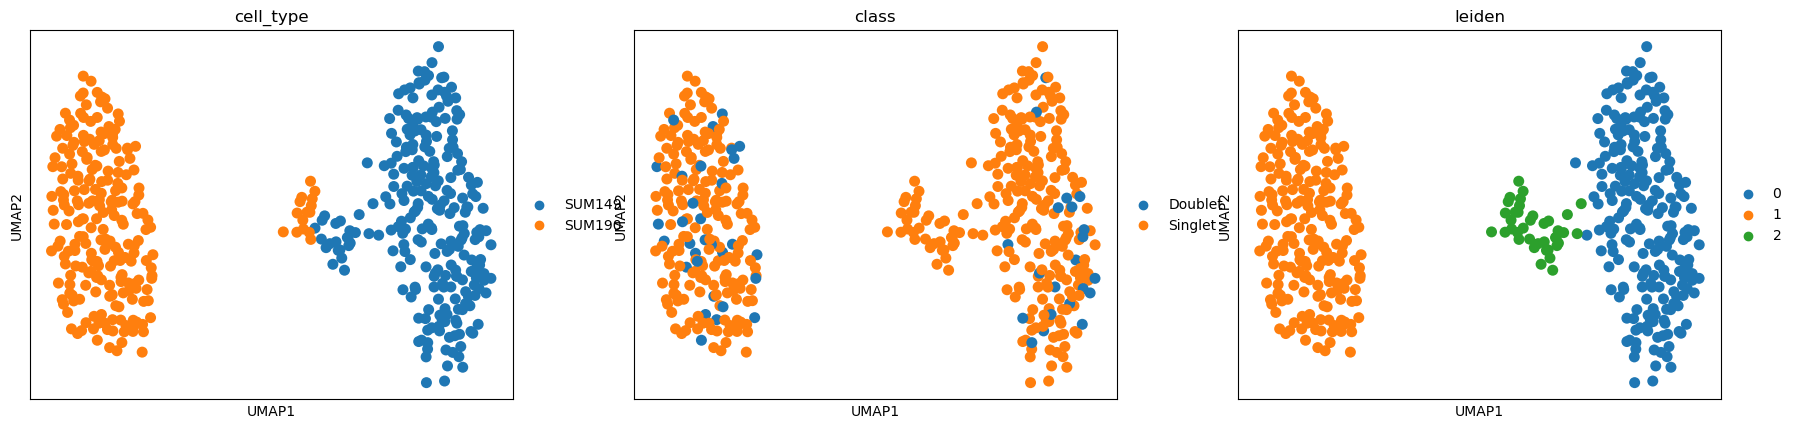

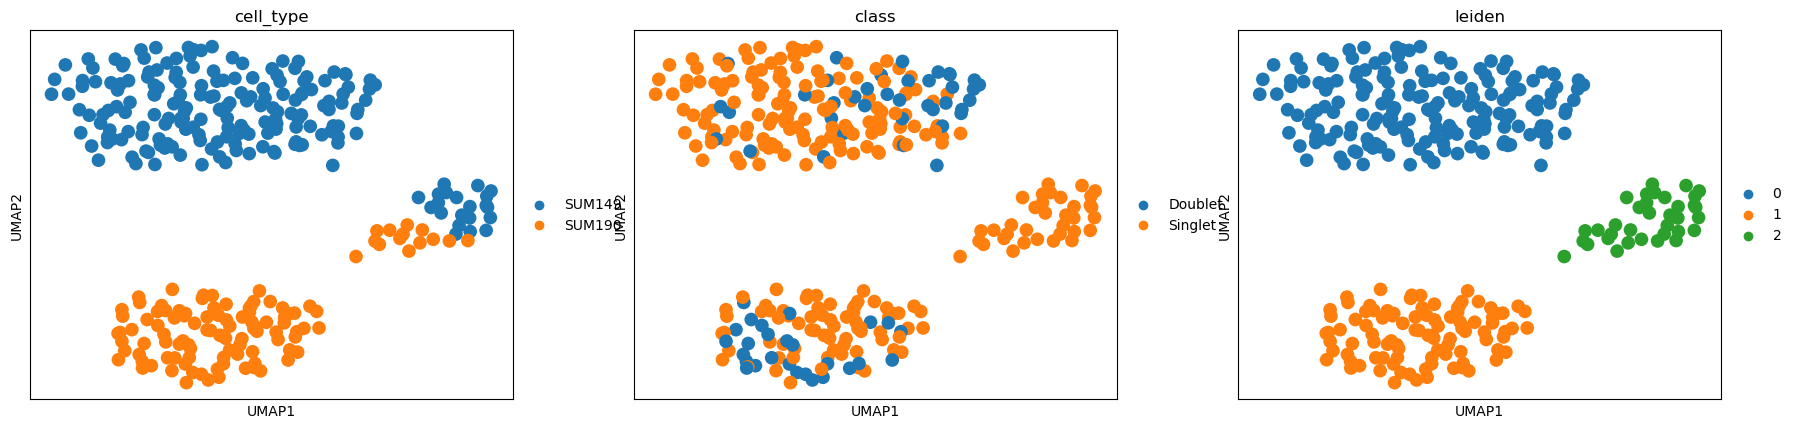

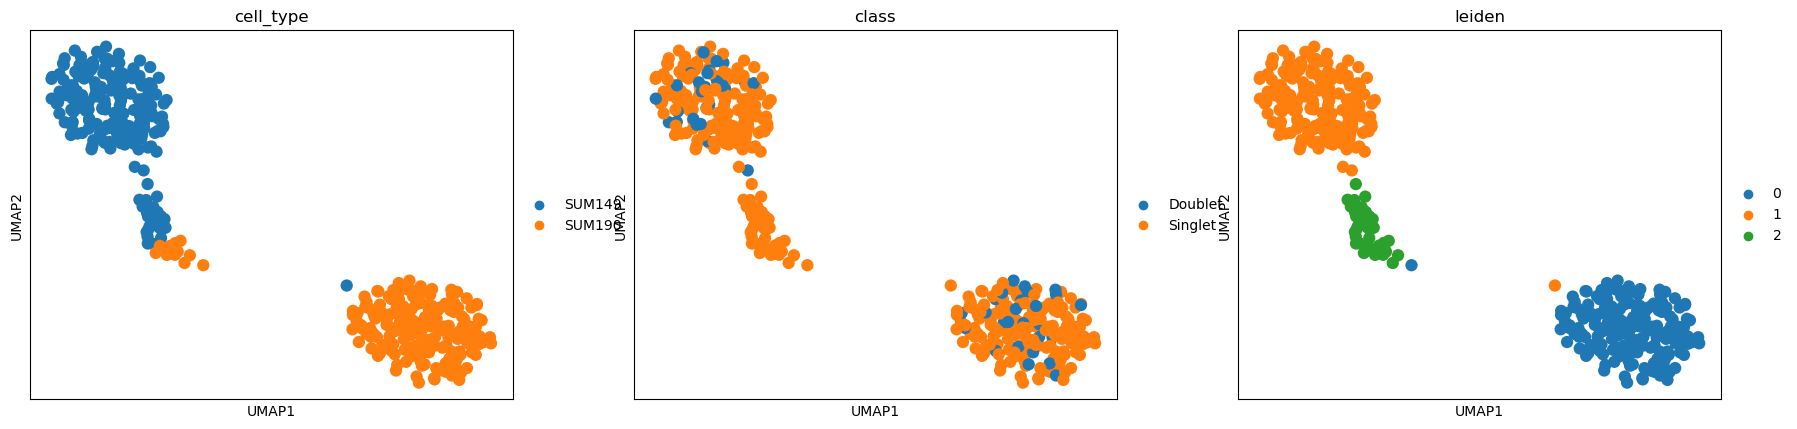

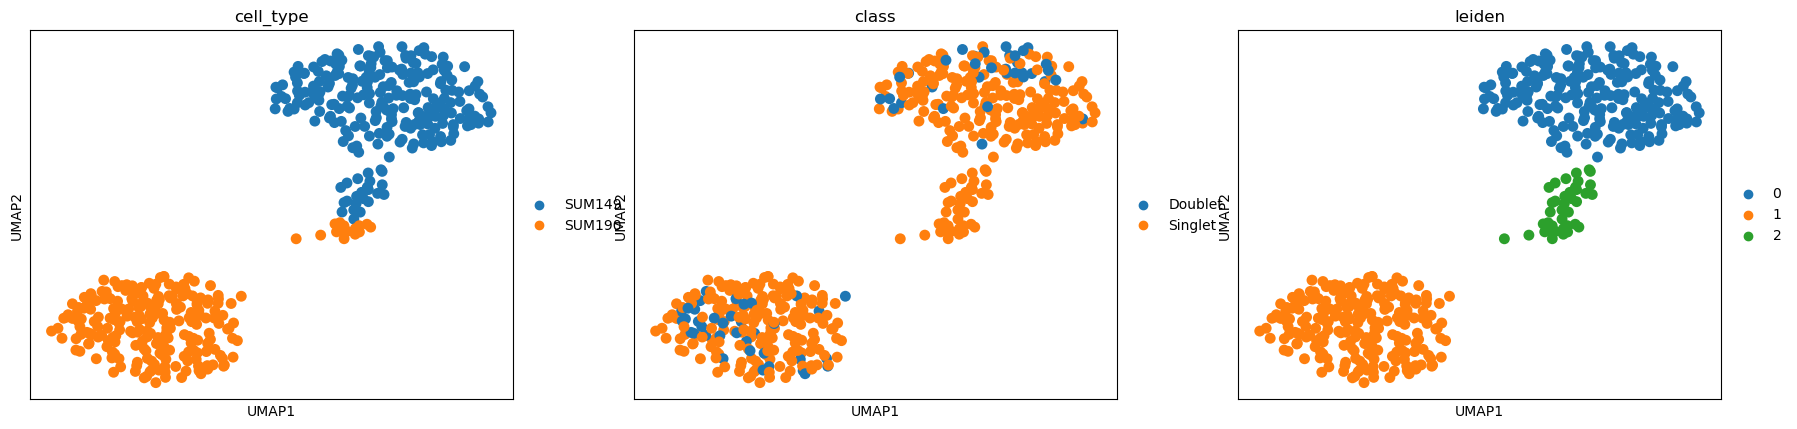

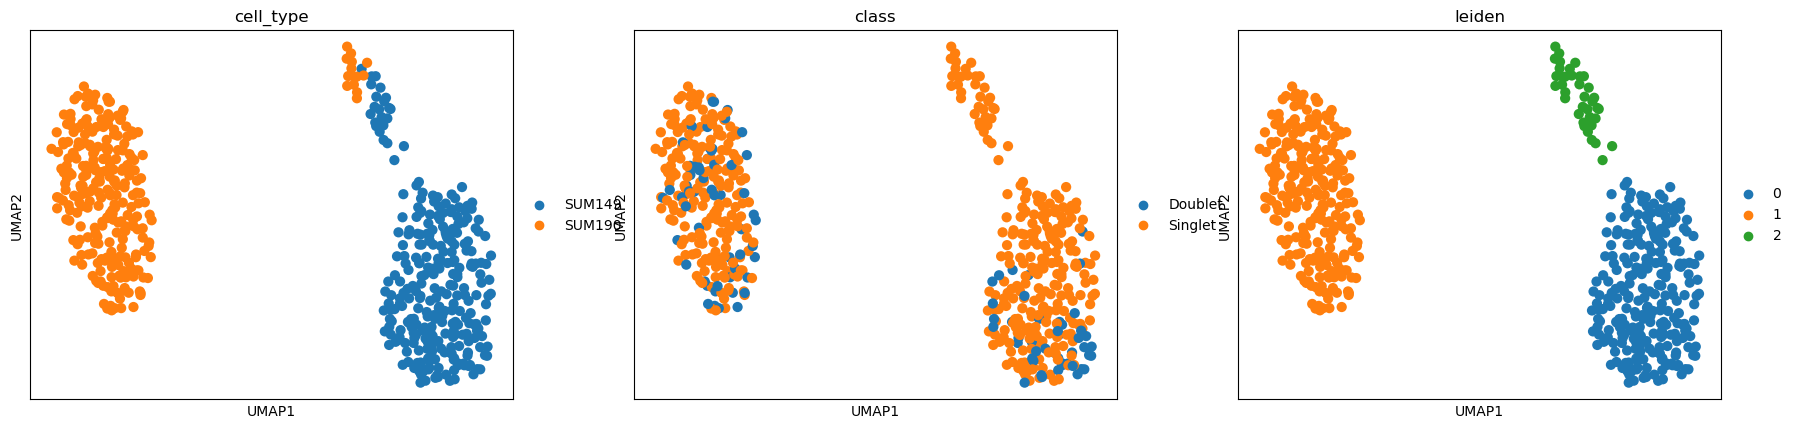

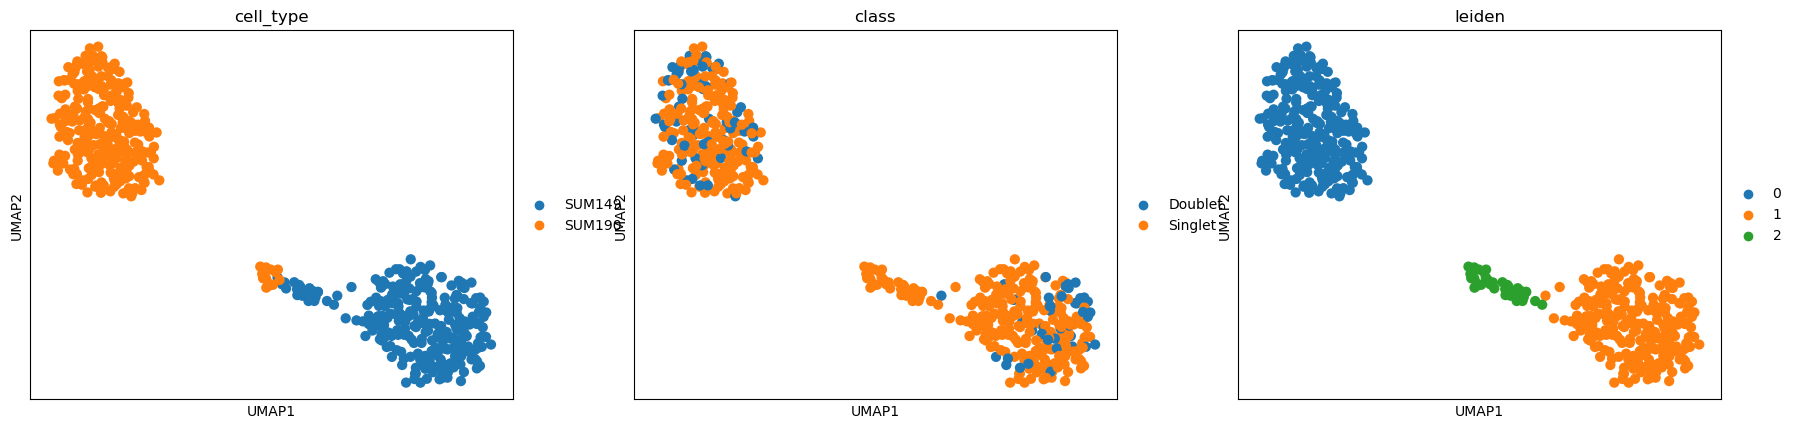

In [11]:
# try removing the missings
adata_img11 = adata_img11[adata_img11.obs["class"] != "Missing"]
umap_data_of_removal = pd.DataFrame()
umap_data_of_removal = pd.concat([
    umap_data_of_removal,
    get_umap_of_removal(adata_img11, None, "no removal"),
    get_umap_of_removal(adata_img11, "class", "Ground-truth"),
    get_umap_of_removal(adata_img11, "pred_image_class", "ImageDoubler"),
    get_umap_of_removal(adata_img11, "pred_doubletdetection", "DoubletDetection"),
    get_umap_of_removal(adata_img11, "pred_scrublet", "Scrublet"),
    get_umap_of_removal(adata_img11, "pred_solo", "Solo"),
    get_umap_of_removal(adata_img11, "pred_scds", "scds"),
    get_umap_of_removal(adata_img11, "pred_scDblFinder", "scDblFinder"),
    get_umap_of_removal(adata_img11, "pred_doubletfinder", "DoubletFinder"),
], ignore_index=True)
umap_data_of_removal.to_csv("Figure5/umap_data_removal_img11_noMissing.csv", index=False)

cluster_acc = []
for method in np.unique(umap_data_of_removal["detectiont_method"]):
    cluster_acc.append(
        [
            method,
            adjusted_mutual_info_score(
                umap_data_of_removal.loc[umap_data_of_removal["detectiont_method"] == method, "cell_type"],
                umap_data_of_removal.loc[umap_data_of_removal["detectiont_method"] == method, "leiden"],
            ),
            adjusted_rand_score(
                umap_data_of_removal.loc[umap_data_of_removal["detectiont_method"] == method, "cell_type"],
                umap_data_of_removal.loc[umap_data_of_removal["detectiont_method"] == method, "leiden"],
            ),
        ]
    )
cluster_acc = pd.DataFrame(cluster_acc, columns=["method", "AMI", "RI"])
cluster_acc.to_csv("Figure5/cluster_acc_img11_noMissing.csv", index=False)